In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Datasets

In [2]:
# import file City_day dan simpan dalam variable df
df = pd.read_csv("datasets/City_day.csv", parse_dates=["Date"])

# ambil data yang data targetnya tidak kosong
df = df[df["Air_quality"].notna()]

# reset index karena jumlah data pasti berkurang
df = df.reset_index()

# hapus kolom index lama
df = df.drop(columns="index")

# tampilkan dataframe
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Air_quality
0,Ahmedabad,2015-01-29,83.13,NaN,6.93,28.71,33.72,NaN,6.93,49.52,59.76,0.02,0.00,3.14,209.0,Poor
1,Ahmedabad,2015-01-30,79.84,NaN,13.85,28.68,41.08,NaN,13.85,48.49,97.07,0.04,0.00,4.81,328.0,Very Poor
2,Ahmedabad,2015-01-31,94.52,NaN,24.39,32.66,52.61,NaN,24.39,67.39,111.33,0.24,0.01,7.67,514.0,Severe
3,Ahmedabad,2015-02-01,135.99,NaN,43.48,42.08,84.57,NaN,43.48,75.23,102.70,0.40,0.04,25.87,782.0,Severe
4,Ahmedabad,2015-02-02,178.33,NaN,54.56,35.31,72.80,NaN,54.56,55.04,107.38,0.46,0.06,35.61,914.0,Severe


Karena dalam siklus angin biasanya tahun dan bulan juga dapat mempengaruhi kualitas udara, oleh karena itu dalam kolom Date akan kita lakukan ekstraksi fitur dengan mengambil data tahun dan data bulan.

In [3]:
# buat kolom year yang berisi data tahun hasil ekstraksi kolom date
df['year'] = pd.DatetimeIndex(df['Date']).year

# buat kolom month yang berisi hasil ekstraksi bulan pada kolom date
df['month'] = pd.DatetimeIndex(df['Date']).month

# hapus kolom Date karena sudah tidak terpakai
df = df.drop(columns="Date")

# tampilkan dataframe
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Air_quality,year,month
0,Ahmedabad,83.13,NaN,6.93,28.71,33.72,NaN,6.93,49.52,59.76,0.02,0.00,3.14,209.0,Poor,2015,1
1,Ahmedabad,79.84,NaN,13.85,28.68,41.08,NaN,13.85,48.49,97.07,0.04,0.00,4.81,328.0,Very Poor,2015,1
2,Ahmedabad,94.52,NaN,24.39,32.66,52.61,NaN,24.39,67.39,111.33,0.24,0.01,7.67,514.0,Severe,2015,1
3,Ahmedabad,135.99,NaN,43.48,42.08,84.57,NaN,43.48,75.23,102.70,0.40,0.04,25.87,782.0,Severe,2015,2
4,Ahmedabad,178.33,NaN,54.56,35.31,72.80,NaN,54.56,55.04,107.38,0.46,0.06,35.61,914.0,Severe,2015,2


### Cek Data yang bolong

,missing_value,%
City,0,0.00
PM2.5,635,2.89
PM10,6975,31.80
NO,308,1.40
NO2,305,1.39
NOx,1785,8.14
NH3,6323,28.82
CO,416,1.90
SO2,554,2.53
O3,709,3.23


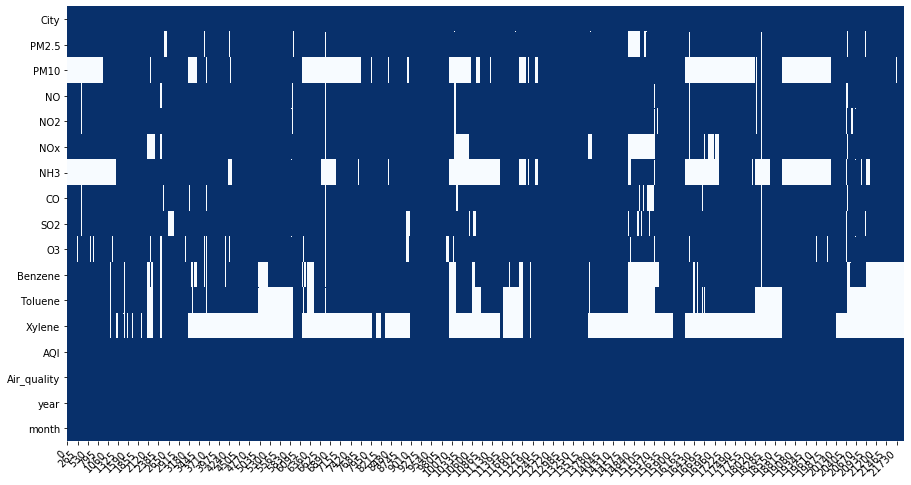

In [4]:
plot_missing_value(df, return_df=True)

Hapus kolom yang datanya bolong lebih dari 10%

In [5]:
# hapus kolom yang memiliki data bolong diatas 10%
df.drop(columns=["Xylene","PM10","NH3","Benzene","Toluene"], inplace=True)

# tampilkan 5 data teratas
df.head()

,City,PM2.5,NO,NO2,NOx,CO,SO2,O3,AQI,Air_quality,year,month
0,Ahmedabad,83.13,6.93,28.71,33.72,6.93,49.52,59.76,209.0,Poor,2015,1
1,Ahmedabad,79.84,13.85,28.68,41.08,13.85,48.49,97.07,328.0,Very Poor,2015,1
2,Ahmedabad,94.52,24.39,32.66,52.61,24.39,67.39,111.33,514.0,Severe,2015,1
3,Ahmedabad,135.99,43.48,42.08,84.57,43.48,75.23,102.70,782.0,Severe,2015,2
4,Ahmedabad,178.33,54.56,35.31,72.80,54.56,55.04,107.38,914.0,Severe,2015,2


# cek data target

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

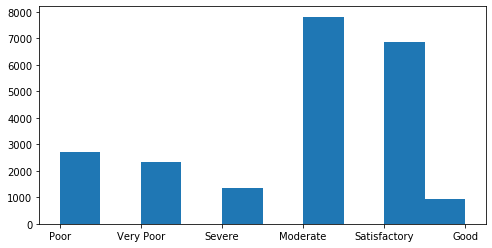

In [9]:
plt.figure(figsize=(8, 4))
ax = plt.hist(df["Air_quality"])

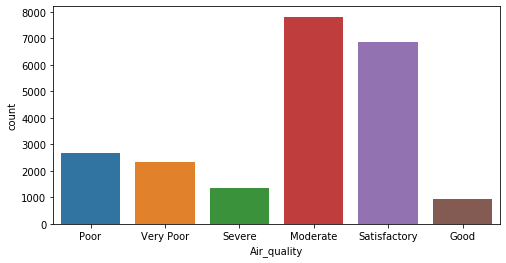

In [10]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df, x="Air_quality")

Persebaran data dalam kolom target tidak merata
# Think Simple
## Datasets Splitting

In [11]:
X = df.drop(columns="Air_quality")
y = df["Air_quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17549, 11), (4388, 11), (17549,), (4388,))

## Preprocessor

In [13]:
# import PCA
from sklearn.decomposition import PCA

# import KNN
from sklearn.neighbors import KNeighborsClassifier

In [14]:
X_train.head(3)

,City,PM2.5,NO,NO2,NOx,CO,SO2,O3,AQI,year,month
17277,Lucknow,163.42,23.57,60.30,47.29,0.49,13.52,38.72,319.0,2018,4
12640,Hyderabad,9.75,7.21,11.87,6.08,0.13,6.13,31.55,66.0,2017,7
12331,Hyderabad,16.93,7.20,12.04,19.24,8.34,5.98,8.35,247.0,2016,7


In [19]:
# buat pipeline dengan nama preprocessor
preprocessor = ColumnTransformer([
    # untuk kolom numeric
    ('numeric', num_pipe(scaling='minmax', transform='yeo-johnson'), ["PM2.5","NO","NO2","NOx","CO","SO2","O3","AQI"]),
    
    # untuk kolom categoric
    ('categoric', cat_pipe(encoder='onehot'), ["City","year","month"]),
])

# buat pipeline dengan nama Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

C:\Users\ROG\anaconda3\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


## Training

In [20]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [21]:
model = GridSearchCV(pipeline, gsp.knn_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  9.3min finished


{'algo__n_neighbors': 27, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.795145063392627 0.8017319963536919


# Feature Engineering

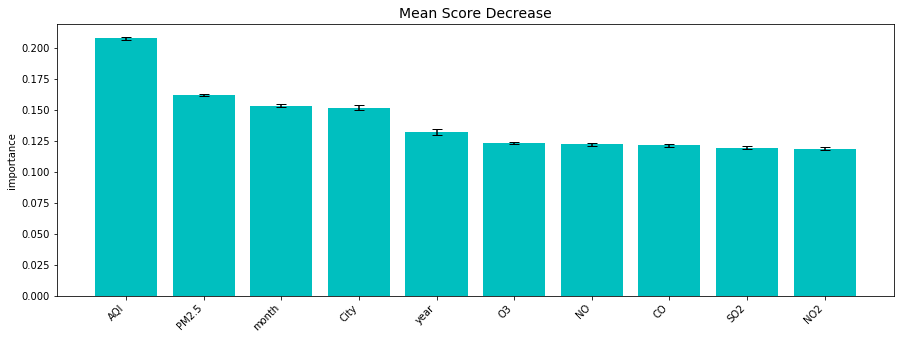

In [22]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

Semua kolom termasuk "penting" dalam pemodelan tersebut
# Tambahkan Polynomial
## Preprocessor

In [23]:
# buat pipeline dengan nama preprocessor
preprocessor = ColumnTransformer([
    # untuk kolom numeric
    ('numeric', num_pipe(poly=2, scaling='minmax', transform='yeo-johnson'), ["PM2.5","NO","NO2","NOx","CO","SO2","O3","AQI"]),
    
    # untuk kolom categoric
    ('categoric', cat_pipe(encoder='onehot'), ["City","year","month"]),
])

# buat pipeline dengan nama Pipeline
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

C:\Users\ROG\anaconda3\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


## Training

In [ ]:
parameter_tune = {
    'prep__numeric__poly__degree': [1, 2, 3, 4],
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__n_neighbors': [25, 27, 29],
    'algo__weights': ['uniform', 'distance'],
    'algo__p': [1, 1.5, 2]}

model = GridSearchCV(pipeline, parameter_tune, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 27.2min
